# Visualizions
## Visualize sidewalk polygons

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd

import upcp.utils.bgt_utils as bgt_utils
import upcp.utils.las_utils as las_utils

In [2]:
tilecode = '2386_9702'
((x_min, y_max), (x_max, y_min)) = las_utils.get_bbox_from_tile_code(tilecode, padding=1)

# Create reader for BGT sidewalk part polygons.
bgt_road_file = '../datasets/bgt/bgt_voetpad.csv'
bgt_sidewalk_reader = bgt_utils.BGTPolyReader(bgt_file=bgt_road_file)

sidewalk_polygons = bgt_sidewalk_reader.filter_tile(
                            tilecode, bgt_types=['voetpad'],
                            padding=0, offset=0,
                            merge=False)

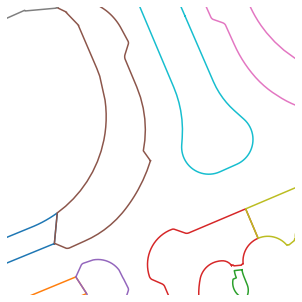

In [3]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.plot(x,y)
    
plt.savefig('../media/examples/sidewalk.png', bbox_inches='tight')

## 2D Visualization of obstacles

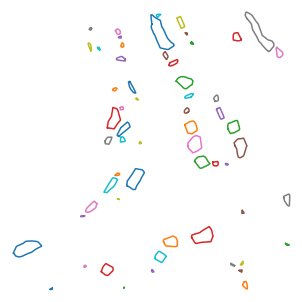

In [4]:
# Read sidewalk with obstacles as interiors
df = gpd.read_file('../datasets/obstacles/obstacles.shp')

fig = plt.figure(figsize=(4, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

for index, row in df.iterrows():
    sidewalk_obstacles = row['geometry']
    x,y = sidewalk_obstacles.exterior.xy
    plt.plot(x,y)

plt.savefig('../media/examples/obstacles.png')

## Plot exterior and interior polygons

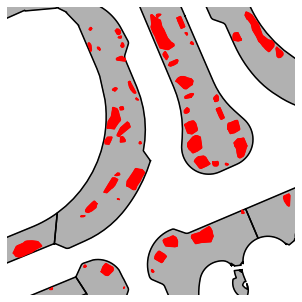

In [5]:
# Read sidewalk with obstacles as interiors
df = gpd.read_file('../datasets/obstacles/sidewalks_merged.shp')

fig = plt.figure(figsize=(4, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

# Plot the result
for index, row in df.iterrows():
    sidewalk_obstacles = row['geometry']
    x, y = sidewalk_obstacles.exterior.xy
    plt.fill(x, y, c="black", alpha=0.30)

    plt.plot(x, y, c="black")
    interiors = sidewalk_obstacles.interiors
    for interior in interiors:
        x, y = interior.xy
        plt.fill(x, y, c="red")
        plt.plot(x, y, c="red")
    
plt.savefig('../media/examples/sidewalk_with_obstacles.png', bbox_inches='tight')